In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import re
from glob import glob
import wave
import math
from itertools import permutations
from collections import Counter
import time

import numpy as np
from scipy import stats, signal
import matplotlib.pyplot as plt

import essentia.standard as es

code_dir = os.path.dirname(os.getcwd())
sys.path.append(code_dir)
from model.utils.audio_utils import load_audio, max_normalize

import IPython.display as ipd

[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


In [2]:
mp3_dir = "/mnt/mtgdb-audio/incoming/fma/audio"
mp3_paths = glob(os.path.join(mp3_dir, "**", "*.mp3"), recursive=True)
print(len(mp3_paths))

106574


## Read sox_log

In [4]:
with open("/home/oaraz/nextcore/fingerprinting/datasets/_fma_wav_8k-2/sox_log.txt", "r") as in_f:
    logs = [line.strip() for line in in_f.readlines()]
print(len(logs))

286909


In [18]:
track_indices = []
for i,line in enumerate(logs):
    if 'processing /mnt/mtgdb-audio/incoming/fma/audio/' in line:
        track_indices.append(i)
        
warning_groups = []
for i in track_indices:
    if i+1 <= len(logs)-1 and "sox WARN" in logs[i+1]:
        warning_groups.append([i, i+1])
    if i+2 <= len(logs)-1 and "sox WARN" in logs[i+2]:
        warning_groups[-1].append(i+2)
print(len(warning_groups))

37217


In [27]:
warning_paths = []
_pattern = r'/mnt/mtgdb-audio/incoming/fma/audio/.*\.mp3'
for warning_group in warning_groups:

    warning_paths.append(re.findall(_pattern, logs[warning_group[0]])[0])
print(len(warning_paths))

37217


In [29]:
#with open("fma_sox_clipped.txt", "w") as o_f:
#    o_f.write('\n'.join(warning_paths)+'\n')

In [32]:
warning_types = set()
clip_amounts = dict()
for i,warning_group in enumerate(warning_groups):

    track_row = logs[warning_group[0]]
    track_idx = track_row.split("/")[-1]
    clip_amounts[track_idx] = {}

    for row_idx in warning_group[1:]:
        
        row = logs[row_idx]

        warning_type = re.findall(r'WARN\s[a-zA-Z]+:', row)[0][5:-1]
        warning_types.update({warning_type})
        
        clip_amount = int(re.findall(r'\d+', row)[0])
        
        clip_amounts[track_idx][warning_type] = clip_amount
print(warning_types)

{'rate', 'dither'}


In [7]:
rate_counter = Counter()
dither_counter = Counter()
counter = 0
for track_id,clip_dict in clip_amounts.items():

    if 'rate' in clip_dict:
        clip_amount = clip_dict['rate']
        if clip_amount > 8000:
            rate_counter[clip_amount] += 1
            counter += 1
            continue

    if 'dither' in clip_dict:
        clip_amount = clip_dict['dither']
        if clip_amount > 8000:
            dither_counter[clip_amount] += 1
            counter += 1

print(f"{counter:,} tracks have a lot of clipped samples.")

rate_clips = list(rate_counter.keys())
print(f"  Mean: {np.mean(rate_clips):,}")
print(f"Median: {np.median(rate_clips):,}")
print(f"   Max: {np.max(rate_clips):,}")
print()

#dither_clips = list(dither_counter.keys())
#print(f"  Mean: {np.mean(dither_clips):,}")
#print(f"Median: {np.median(dither_clips):,}")
#print(f"   Max: {np.max(dither_clips):,}")

1,502 tracks have a lot of clipped samples.
  Mean: 72,078.24794520548
Median: 26,071.5
   Max: 2,163,088



In [34]:
rate_counter = Counter()
dither_counter = Counter()
counter = 0
for track_id,clip_dict in clip_amounts.items():

    if 'rate' in clip_dict:
        clip_amount = clip_dict['rate']
        rate_counter[clip_amount] += 1
        counter += 1

    if 'dither' in clip_dict:
        clip_amount = clip_dict['dither']
        dither_counter[clip_amount] += 1
        counter += 1

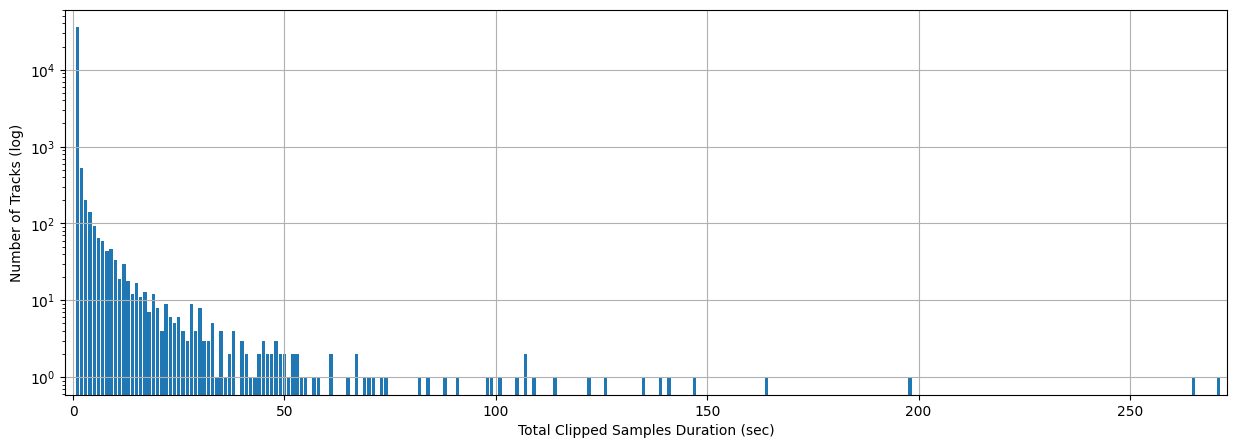

In [35]:
rate_counter = {k: v for k,v in sorted(rate_counter.items())}
_rate_counter = {}

for i in range(1, list(rate_counter.keys())[-1]//8000+1+1):
    _rate_counter[i] = 0
    for k,v in rate_counter.items():
        if k >= (i-1)*8000 and k<i*8000:
            _rate_counter[i] += v

fig, ax = plt.subplots(figsize=(15,5))
ax.bar(_rate_counter.keys(), _rate_counter.values())
ax.set_yscale("log")
ax.set_xlabel("Total Clipped Samples Duration (sec)")
ax.set_ylabel("Number of Tracks (log)")
ax.set_xlim([-2,list(_rate_counter.keys())[-1]+2])
ax.grid()
plt.show()

### Listen / Plot Clipped Tracks

In [ ]:
for track_id,clip_dict in clip_amounts.items():
    if clip_dict.get('rate', 0) > 1*8000:
        print(track_id)
        print(clip_dict.get('rate', 0))
        break

In [ ]:
mp3_path = os.path.join(mp3_dir, track_id[:3], track_id)
print(mp3_path)
audio, fs, numberChannels, _, bit_rate, codec = es.AudioLoader(filename=mp3_path)()
print(audio.shape)
audio = np.mean(audio, axis=1)
print(time.strftime('%H:%M:%S', time.gmtime(audio.shape[0]/fs)))

In [ ]:
fig,ax = plt.subplots(figsize=(15,8))
ax.plot(audio)
plt.show()

In [ ]:
ipd.display(ipd.Audio(audio, rate=fs, normalize=False))

In [ ]:
ipd.Audio("/home/oaraz/nextcore/fingerprinting/datasets/fma_wav_8k/audio/139/139025.wav")

## Effect of --norm=0

In [ ]:
wav_paths = glob(os.path.join(code_dir, "*.wav"))
print("\n".join(wav_paths))

In [ ]:
wav1 = load_audio("/home/oaraz/nextcore/fingerprinting/neural-audio-fp/lol.wav")
wav1_norm = load_audio("/home/oaraz/nextcore/fingerprinting/neural-audio-fp/lol_norm.wav")

In [ ]:
np.max(np.abs(wav1))

In [ ]:
np.max(np.abs(wav1_norm))

In [ ]:
np.max(np.abs(wav1_norm-wav1))

In [ ]:
wav1_np_norm = max_normalize(wav1)
print(np.max(np.abs(wav1_np_norm-wav1)))

In [ ]:
wav1_norm_np_norm = max_normalize(wav1_norm)
print(np.max(np.abs(wav1_norm_np_norm-wav1_norm)))

In [ ]:
2**16

In [ ]:
1/32767

## Effect of Auto-gain and Dither

In [42]:
def plot_time_signal(ax, x, fs, title=""):
    

    N = len(x)
    t = np.arange(N) / fs
    T = t[-1]
    
    if T < 15:
        tick_interval = 1
    elif T < 30:
        tick_interval = 2
    elif T < 60:
        tick_interval = 4
    elif T < 120:
        tick_interval = 8
    elif T < 240:
        tick_interval = 10        
    elif T < 480:
        tick_interval = 30
    else:
        tick_interval = 90

    ax.plot(t, x)
    
    if title != "":
        ax.set_title(title, fontsize=17)
    
    max_time = N / fs
    x_ticks = np.arange(0, max_time, tick_interval)
    # Format labels to decimal place
    if tick_interval > 30:
        x_tick_labels = [f"{x:.0f}" for x in x_ticks]
    else:
        x_tick_labels = [f"{x:.1f}" for x in x_ticks]
    ax.set_xticks(x_ticks, x_tick_labels)
    ax.set_xlim([-tick_interval/5,max_time+tick_interval/5])
    ax.set_xlabel("Time (sec)", fontsize=13)

    ax.set_yticks(np.arange(-1, 1.1, 0.1))
    ax.set_ylim([-1.05, 1.05])
    ax.set_ylabel("Amplitude", fontsize=13)

    ax.grid()

In [ ]:
wav_paths = glob(os.path.join(code_dir, "*.wav"))

In [ ]:
wav_paths

In [36]:
mp3_path = '/mnt/mtgdb-audio/incoming/fma/audio/056/056041.mp3'
direct_path = '/home/oaraz/nextcore/fingerprinting/neural-audio-fp/056041.wav'
gain_path = '/home/oaraz/nextcore/fingerprinting/neural-audio-fp/056041-gain.wav'
gain_norm_path = '/home/oaraz/nextcore/fingerprinting/neural-audio-fp/056041-gain-norm.wav'
gain_no_dither_path = '/home/oaraz/nextcore/fingerprinting/neural-audio-fp/056041-gain-no_dither.wav'

In [37]:
mp3 = load_audio(mp3_path, fs=8000, normalize=False)
direct_wav = load_audio(direct_path, normalize=False)
gain_wav = load_audio(gain_path, normalize=False)
gain_no_dither_wav = load_audio(gain_no_dither_path, normalize=False)
gain_norm_wav = load_audio(gain_norm_path, normalize=False)

print(np.max(np.abs(gain_norm_wav-gain_wav)))
print(np.max(np.abs(gain_norm_wav-direct_wav)))

6.103515625e-05
0.25244140625


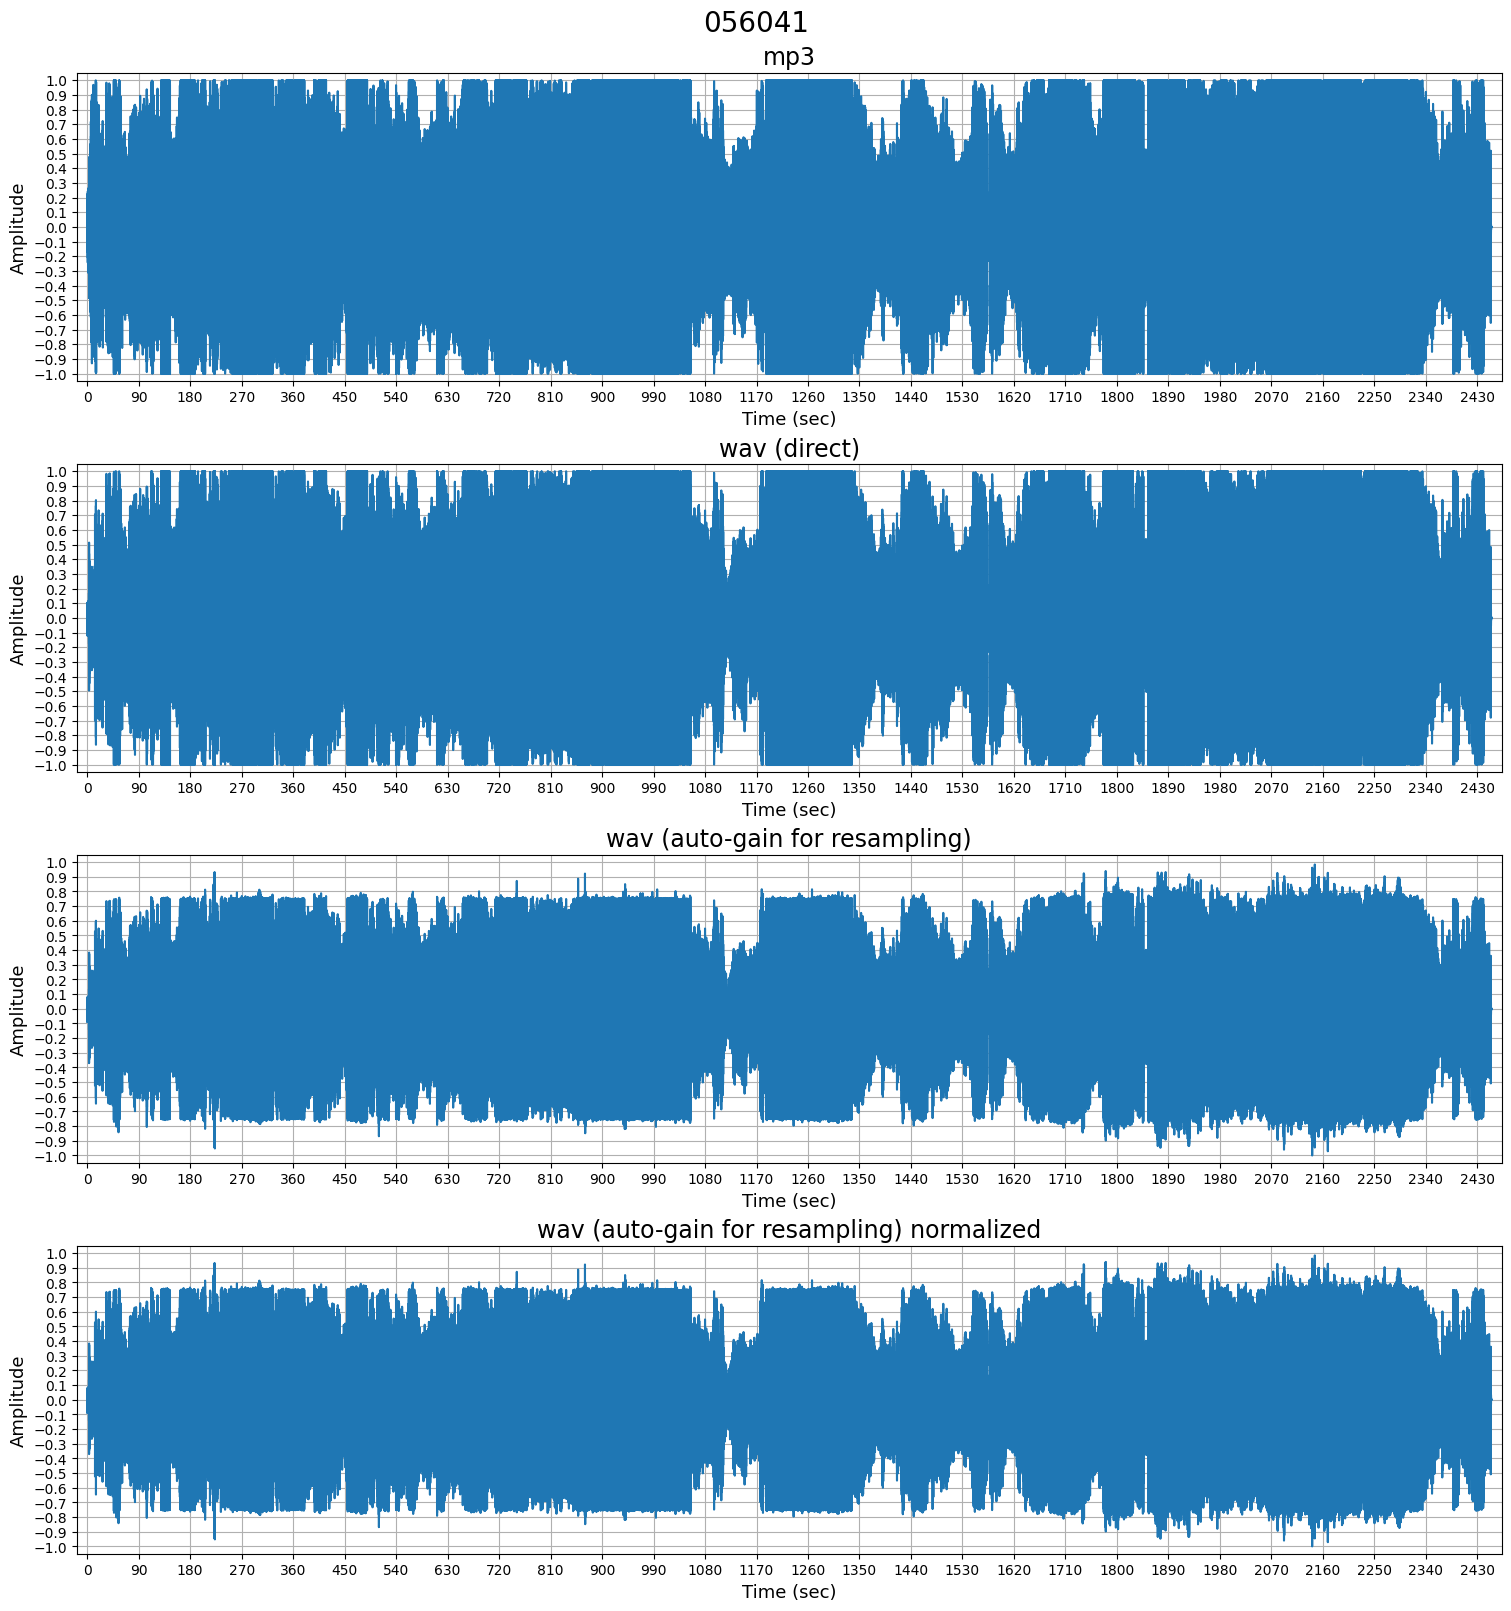

In [43]:
fig,ax = plt.subplots(nrows=4, figsize=(15,16), constrained_layout=True)

fig.suptitle(os.path.splitext(os.path.basename(mp3_path))[0], fontsize=20)

fs = 8000

plot_time_signal(ax[0], mp3, fs, title="mp3")
plot_time_signal(ax[1], direct_wav, fs, title="wav (direct)")
plot_time_signal(ax[2], gain_wav, fs, title="wav (auto-gain for resampling)")
plot_time_signal(ax[3], gain_norm_wav, fs, title="wav (auto-gain for resampling) normalized")
    
plt.show()

In [ ]:
ipd.display(ipd.Audio(wav, rate=fs))

## No Sox Warning

In [ ]:
wav_paths = glob(os.path.join(code_dir, "*.wav"))
wav_paths

In [ ]:
mp3_path = "/mnt/mtgdb-audio/incoming/fma/audio/106/106426.mp3"
wav_path = "/home/oaraz/nextcore/fingerprinting/datasets/fma_wav_8k/audio/106/106426.wav"
wav_g_path = '/home/oaraz/nextcore/fingerprinting/neural-audio-fp/106426-gain.wav'
wav_g_norm_path = '/home/oaraz/nextcore/fingerprinting/neural-audio-fp/106426-gain-norm.wav'

mp3 = load_audio(mp3_path, fs=8000, normalize=False)
wav = load_audio(wav_path, normalize=False)
wav_gain = load_audio(wav_g_path, normalize=False)
wav_gain_norm = load_audio(wav_g_norm_path, normalize=False)

signals = [mp3, wav, wav_gain, wav_gain_norm]
for signal in signals:
    print(np.max(np.abs(signal)))

In [ ]:
fig,ax = plt.subplots(nrows=4, figsize=(15,16), constrained_layout=True)

fig.suptitle(os.path.splitext(os.path.basename(mp3_path))[0], fontsize=20)

fs = 8000

plot_time_signal(ax[0], mp3, fs, title="mp3")
plot_time_signal(ax[1], wav, fs, title="wav (direct)")
plot_time_signal(ax[2], wav_gain, fs, title="wav (auto gain)")
plot_time_signal(ax[3], wav_gain_norm, fs, title="wav (auto gain + norm)")
    
plt.show()